# Krypton Lifetime maps

### Author:  JMH, JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Mon Mar 30 16:21:15 2020


### Logger

In [3]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2020-03-30 16:21:15,310 | INFO : Hello world!


### Input files

In [4]:
from krcal.core.kr_types import KrFileName
import subprocess

run_number = 7472
num_files = 9970
analysis_tag = 'x2rg190819'
input_tag = 'x2rg190819'

# For testing
# run_number  = 7435
# num_files = 8895
# analysis_tag = 'x2rg190819'
# input_tag = 'st190819' # we allow analysis using selection and filtering from a different tag

num_xy_bins = 50
regularize = True

# Can conditionally allow 100 x 100, if you like
# if num_files > 7729:
#     num_xy_bins = 100

t_start = time.time()

lifetime_limits = (3000, 8000)
e0_limits = (7000, 14000)
e0_limits_rphi = (12000, 14000)

input_path  = f"$IC_DATA/"+input_tag+"/dst"
output_path = f"$IC_DATA/"+analysis_tag+"/ldst"
map_path    = f"$IC_DATA/"+analysis_tag+"/maps"

output_plots = f"$IC_DATA/plots/"+analysis_tag+"/"
output_plots = os.path.expandvars(f"{output_plots}/")
summary_outputs = "/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r"+str(run_number)+analysis_tag+"/"
previous_summary_outputs = "/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r"+str(run_number)+input_tag+"/"

bash_copydir = "cp -a " + previous_summary_outputs + " " + summary_outputs
process = subprocess.Popen(bash_copydir, stdout=subprocess.PIPE, shell=True).wait()

# Find the name of the correct input dst

dst_directory = os.path.expandvars(f"{input_path}/")
dirlist = os.listdir(dst_directory)
dst_file = ""
for file_name in dirlist:
    try:
        check_number = file_name
        check_number = check_number[check_number.find('_')+1:]
        check_number = check_number[:check_number.find('_')]
        if check_number == str(run_number):
            print('Found the dst:',file_name)
            dst_file = file_name
    except:
        pass

if dst_file == "":
    raise ValueError("Unable to find appropriate dst for run "+str(run_number))

input_file_names  = [ dst_file ]

    
time_bins = 25
output_file_name  = ' '
map_file_name     = 'kr_maps_xy_'+str(run_number)+'.h5'
map_file_name_ts  = f'kr_maps_rphi_5_8_ts_{time_bins}_'+str(run_number)+'.h5'
emap_file_name    = 'kr_emap_xy_'+str(num_xy_bins)+'_'+str(num_xy_bins)+'_r_'+str(run_number)+'_'+analysis_tag+'.h5'

krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

Found the dst: dst_7472_trigger1_0000_9971.h5


### Notebook configuration

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [6]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [7]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
import invisible_cities.reco.corrections      as corrf

In [8]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [9]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [10]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import timeit
from krcal.core.core_functions      import NN
from krcal.core                     import fit_functions_ic as fitf

In [11]:
from krcal.core.plt_functions  import plot_sector
from krcal.core.plt_functions  import plot_sectors

In [12]:
from krcal.core.stat_functions      import mean_and_std

In [13]:
from krcal.core.ranges_and_bins_functions      import kr_ranges_and_bins

In [14]:
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map

from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

In [15]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [16]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

In [17]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [18]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName

In [19]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [20]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average
from krcal.core.map_functions   import add_mapinfo

In [21]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [22]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [23]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [24]:
from krcal.core.selection_functions  import event_map_df
from krcal.core.selection_functions  import select_rphi_sectors_df
from krcal.core.selection_functions  import select_xy_sectors_df
from krcal.core.selection_functions  import get_time_series_df
from krcal.core.fitmap_functions     import time_fcs_df
from krcal.core.fitmap_functions     import fit_fcs_in_rphi_sectors_df
from krcal.core.fitmap_functions     import fit_map_xy_df

In [25]:
from numpy import pi, sqrt

In [26]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [27]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [28]:
log = logging.getLogger()

### Input/output 

In [29]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [30]:
t0 = time.time()
dst           = load_dsts(fn.input_file_names, "DST", "Events")
t1 = time.time()
print(f'Read in file time: t = {t1 -t0}')

Read in file time: t = 11.303154945373535


In [31]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 3775033


In [32]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [33]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [34]:
RMAX      = 200
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 8000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = num_xy_bins,
                                                        ynbins    = num_xy_bins,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [35]:
dstFid = dst[in_range(dst.R, 0, RMAX)]

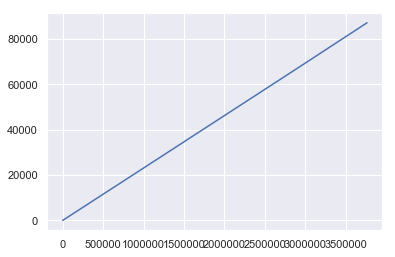

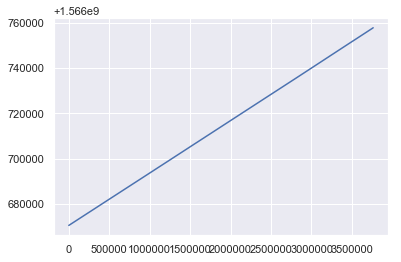

In [36]:
dst_time = dstFid.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)
dst = dst_time.assign(DT=DT)
plt.plot(DT)
plt.show()
plt.plot(T)
plt.show()

In [37]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

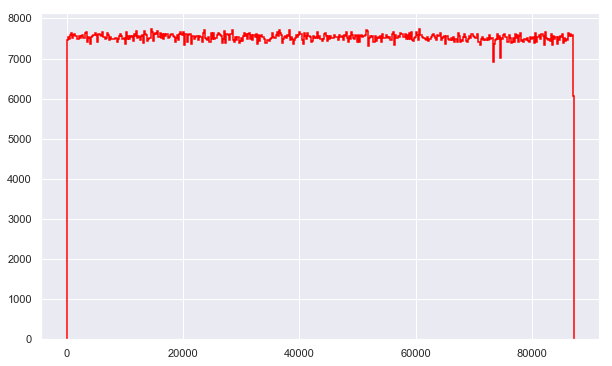

In [38]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

### Time 

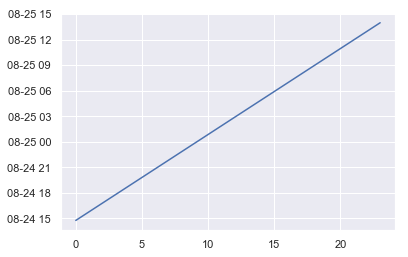

In [39]:
plt.plot(krTimes.timeStamps)

### Event distribution

In [40]:
import subprocess

bash_mkdir = "mkdir " + output_plots
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

bash_mkdir = "mkdir " + output_plots+'/EventDists/'
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

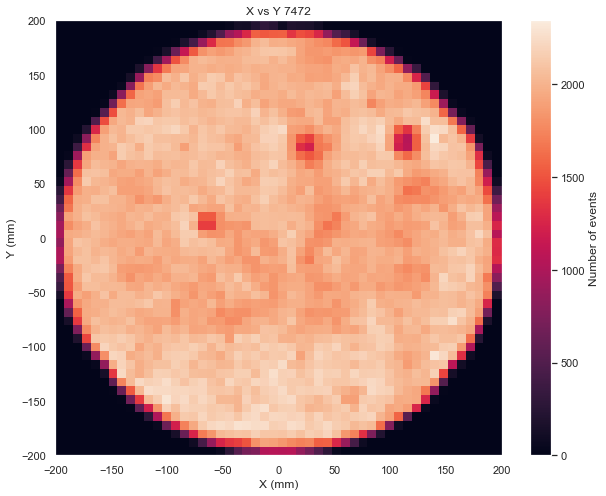

In [41]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y '+str(run_number)),
           profile=False,
           figsize=(10,8))
plt.savefig(output_plots+'/EventDists/EventDist_'+str(run_number)+'.png')

## Time series

In [42]:
log.setLevel(logging.INFO)

### Divide dst in 100 time series

In [43]:
time_bins = 25
t0 = time.time()

RFID = 180
dstfid = dst[in_range(dst.R, 0, RFID)]
ts, masks = get_time_series_df(time_bins, (DT[0],DT[-1]), dstfid) # [edit]
t1 = time.time()
print(f' get_time_series: t = {t1 -t0}')

 get_time_series: t = 2.361232042312622


### Fit lifetime full detector

In [44]:
t0 = time.time()
fps = time_fcs_df(ts, masks, dstfid, 
                 nbins_z = 15,
                 nbins_e = 25,
                 range_z = (10, 550),
                 range_e = (7000, 14000),
                 energy  = 'S2e',
                 fit     = FitType.profile)  # fps: fit-profile series (implicit is a time series, using profile)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')

 time_fcs: t = 2.3163747787475586


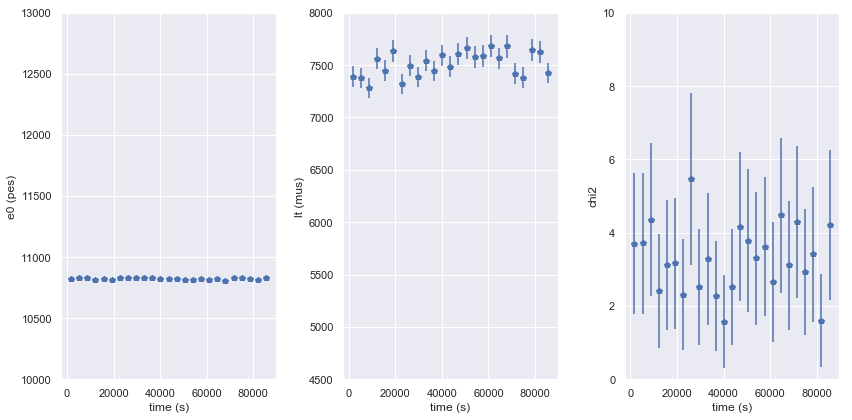

In [45]:
plot_time_fcs(fps,
              range_chi2  = (0,10),
              range_e0    = (10000, 13000),
              range_lt    = (4500, 8000),
              figsize     = (12,6))
plt.savefig(summary_outputs+'AverageLT.png')

### Fit lifetime best region

In [46]:
RINNER = 50
dst_inner = dst[in_range(dst.R, 0, RINNER)]
ts_inner, masks_inner = get_time_series_df(time_bins, (DT[0],DT[-1]), dst_inner) # [edit]

fps_inner = time_fcs_df(ts_inner, masks_inner, dst_inner, 
                 nbins_z = 15,
                 nbins_e = 25,
                 range_z = (10, 550),
                 range_e = (7000, 14000),
                 energy  = 'S2e',
                 fit     = FitType.profile)  # fps: fit-profile series (implicit is a time series, using profile)

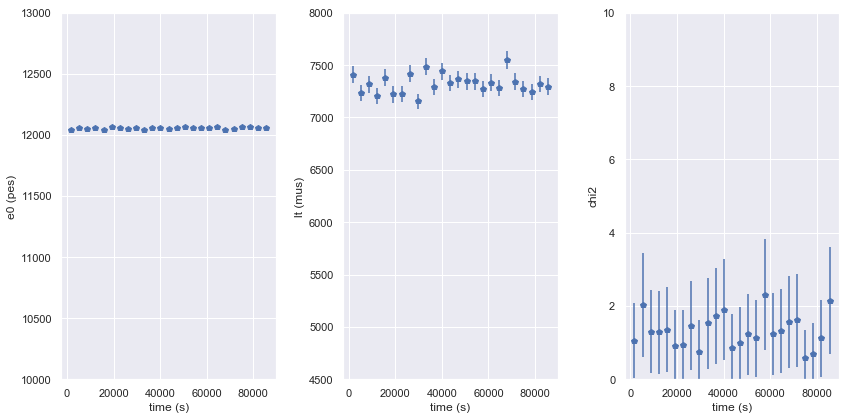

In [47]:
plot_time_fcs(fps_inner,
              range_chi2  = (0,10),
              range_e0    = (10000, 13000),
              range_lt    = (4500, 8000),
              figsize     = (12,6))
plt.savefig(summary_outputs+'AverageLT_fid.png')

## Lifetime in RPhi

In [48]:
NSECTORS =5  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.
#NSECTORS =4  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.
#SPHI     =45 # size of the phi pie-slice in degrees, thus 10 slices in phi.

In [49]:
rpsmd = rphi_sector_map_def(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)

In [50]:
W = define_rphi_sectors(rpsmd)

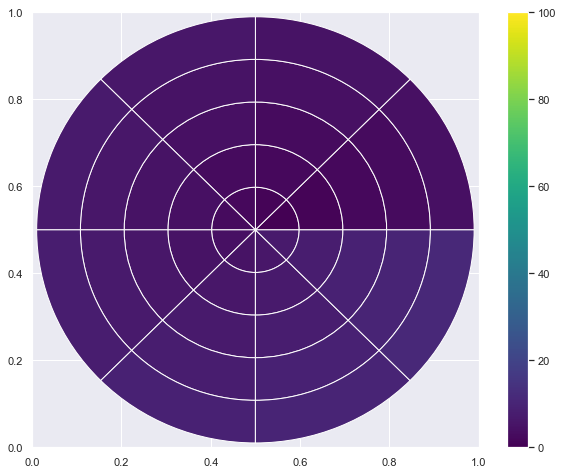

In [51]:
draw_wedges(W,  rmax = RMAX, 
            scale= 0.49, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

In [52]:
t0 = time.time()
#KSRP = select_rphi_sectors(dst, DT, dst.S2e, dst.S2q, W)
KSRP = select_rphi_sectors_df(dst, W) # [edit]
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 KRES: t = 4.027985334396362


In [53]:
neM = event_map_df(KSRP)

In [54]:
neM

,0,1,2,3,4
0,18571,58542,96063,136527,161399
1,18504,56947,99290,145650,167591
2,19399,56964,99293,146009,169587
3,18538,57348,96488,137778,169561
4,19238,55887,97265,127458,159653
5,19808,57342,93576,139165,140081
6,20225,60989,101811,141203,136905
7,19064,55987,100028,137810,148773


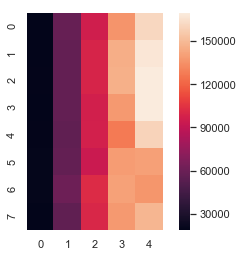

In [55]:
ax = sns.heatmap(neM, square=True)

### four phi sectors: upper half (left-right), lower half (left-right) of chamber

### R < 40 mm

In [56]:
erange = (0,14500)
ltrange = (0, 7000)

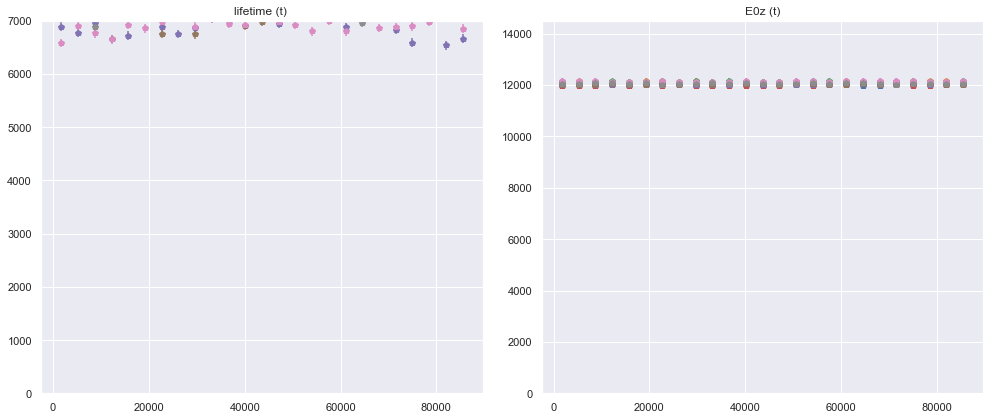

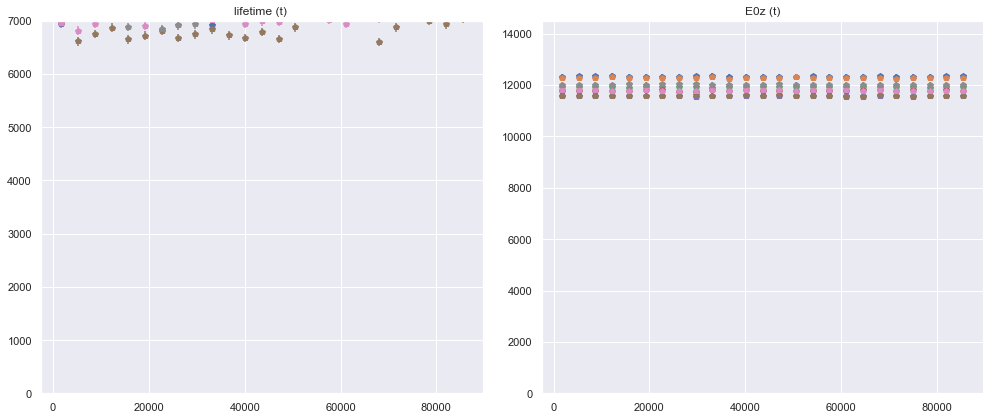

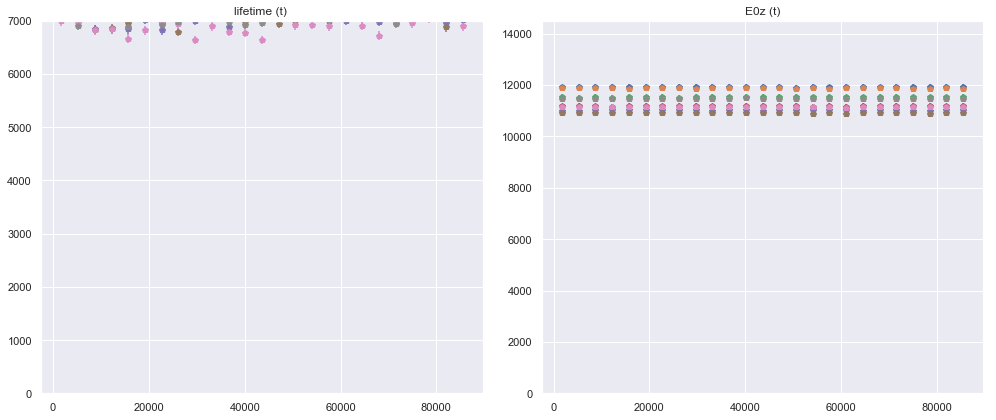

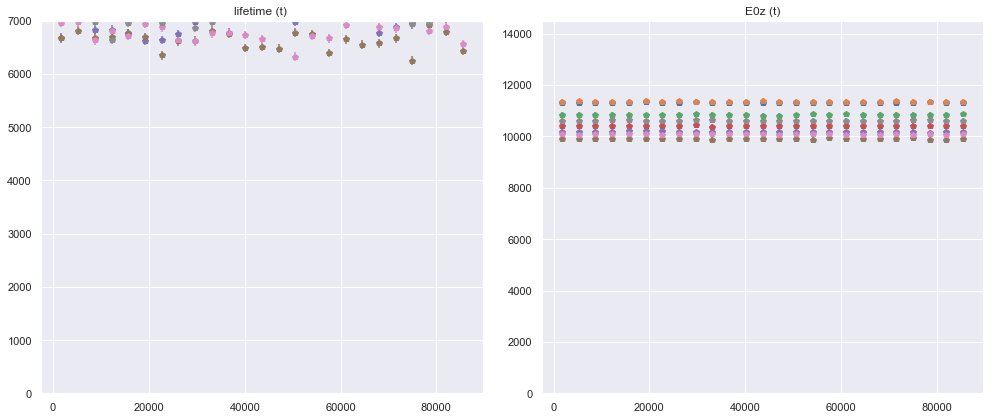

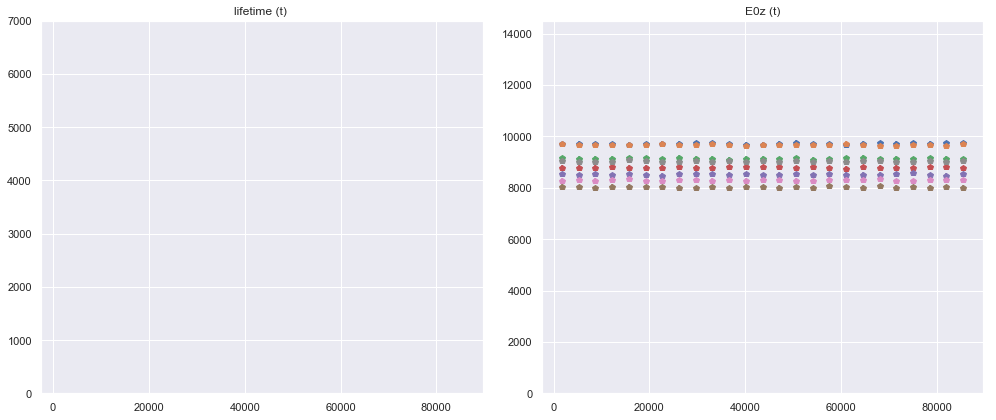

In [57]:
for sector in range(NSECTORS):
    fps_rp = fit_fcs_in_rphi_sectors_df(sector = sector,
                              selection_map = KSRP,
                              event_map     = neM,
                              n_time_bins   = time_bins,
                              time_diffs    = DT,
                              nbins_z       = 25,
                              nbins_e       = 50,
                              range_z       =(50, 550),
                              range_e       = (5000, 14500),
                              energy        = 'S2e',
                              fit           = FitType.unbined,
                              n_min         = 100)
    plot_fit_sectors(fps_rp,  range_e0 =erange, range_lt=ltrange)
    plt.savefig(summary_outputs+'R_phi_lt'+str(sector+1)+'.png')

### Lifetime patterns:

- Oscillatory pattern in time with a swing of 1 ms!
- Lifetime changes also as a function of Phi, with differences that increase as R increases.
- R > 160 cm data shows very high and very variable lifetime, with a spread of several ms.

### Strategy

- Try to correct geometrical effects first. Fine grained geometrical map with a single time bin.
- Study time dependence later

## Divide chamber in sectors of XY

In [58]:
log.setLevel(logging.DEBUG)

In [59]:
t0 = time.time()
print(len(dst))
print(len(DT))
# KRES = select_xy_sectors(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)
KRES = select_xy_sectors_df(dst, krBins.X, krBins.Y) # [edit]
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

3762317
3762317
 KRES: t = 10.946063995361328


In [60]:
log.setLevel(logging.INFO)

In [151]:
neM = event_map_df(KRES)

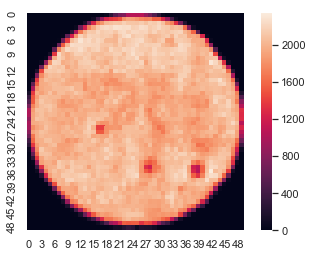

In [62]:
ax = sns.heatmap(neM, square=True)

## Fits in XY sectors

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```


### Single time bin

In [63]:
t0 = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fpmxy = fit_map_xy_df(selection_map = KRES,
                       event_map     = neM,
                       n_time_bins   = 1,
                       time_diffs    = DT,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy        = 'S2e',
                       fit           = FitType.unbined,
                       n_min         = 100)

t1 = time.time()
print(f' fpmxy: t = {t1 -t0}')

 fpmxy: t = 15.081629037857056


In [64]:
times = fpmxy[0][0].ts

In [65]:
times

array([43614.81799996])

#### Obtain time maps from fmap: The object returned is a SectorMapTS
```
@dataclass
class SectorMapTS:  # Map in chamber sector containing time series of pars
    chi2  : Dict[int, List[np.array]]
    e0    : Dict[int, List[np.array]]
    lt    : Dict[int, List[np.array]]
    e0u   : Dict[int, List[np.array]]
    ltu   : Dict[int, List[np.array]]
```
Here the dictionary is arranged for each of the relevant variables.

In [66]:
tsm = tsmap_from_fmap(fpmxy)

<ErrorbarContainer object of 3 artists>

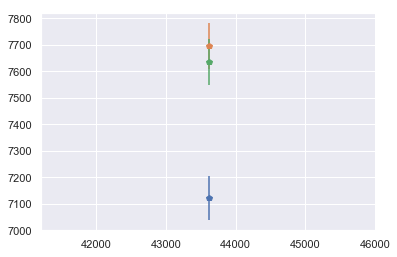

In [67]:
plt.errorbar(times, tsm.lt[25][25], np.sqrt(tsm.lt[25][25]), fmt="p")
plt.errorbar(times, tsm.lt[25][21], np.sqrt(tsm.lt[25][21]), fmt="p")
plt.errorbar(times, tsm.lt[25][22], np.sqrt(tsm.lt[25][22]), fmt="p")

<ErrorbarContainer object of 3 artists>

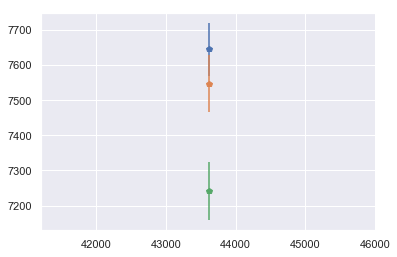

In [68]:
plt.errorbar(times, tsm.lt[30][10], np.sqrt(tsm.lt[6][10]), fmt="p")
plt.errorbar(times, tsm.lt[30][11], np.sqrt(tsm.lt[6][11]), fmt="p")
plt.errorbar(times, tsm.lt[30][12], np.sqrt(tsm.lt[6][12]), fmt="p")

### Obtain amap from tsm: The object returned is ASectorMap
```
@dataclass
class ASectorMap:  # Map in chamber sector containing average of pars
    chi2  : DataFrame
    e0    : DataFrame
    lt    : DataFrame
    e0u   : DataFrame
    ltu   : DataFrame
```
 

#### There is a single time series (ts = 0)

In [147]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [148]:
amap_average(am) 

ASectorMap(chi2=1.135909387453481, e0=10118.669275559967, lt=6815.585237894981, e0u=12.709055683668605, ltu=555.0778703787062, mapinfo=None)

#### Get rid of outlayers that distort mean and error

In [160]:
# Regularize on chi2
def asm_copy(amap):
    return ASectorMap(chi2  = amap.chi2.copy(),
                      e0    = amap.e0.copy(),
                      lt    = amap.lt.copy(),
                      e0u   = amap.e0u.copy(),
                      ltu   = amap.ltu.copy(),
                      mapinfo   = None)


def regularize_maps_chi2(amap_old, x2range):

    amap = asm_copy(amap_old)
    regcells = []
    for i in range(len(amap.lt)):
        for j in range(len(amap.lt[i])):
            if amap.chi2[i][j] > x2range[1] or amap.chi2[i][j] < x2range[0]:
                amap.lt[i][j] = np.nan
                amap.ltu[i][j] = np.nan
                amap.e0[i][j] = np.nan
                amap.e0u[i][j] = np.nan
                regcells.append((i, j))

    print('List of cut cells =', regcells)
    print('Number of cut events =', sum([neM[r[0]][r[1]] for r in regcells]))
    return amap



In [161]:
if regularize:
    rmap = regularize_maps_chi2(am, x2range = (0, 2))
    amap_average(rmap)
    asm = relative_errors(rmap)
else:
    asm = relative_errors(am)

List of cut cells = [(0, 29), (2, 35), (9, 44), (29, 0), (37, 46), (47, 36)]
Number of cut events = 1854


In [162]:
amv = amap_average(asm)

In [163]:
cutcells = [(0, 29), (2, 35), (9, 44), (29, 0), (37, 46), (47, 36)] # note i is x and j is y

#### Draw the maps using default colormap

In [90]:
bash_mkdir = "mkdir " + output_plots+'/lt_e0_xy_maps'
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

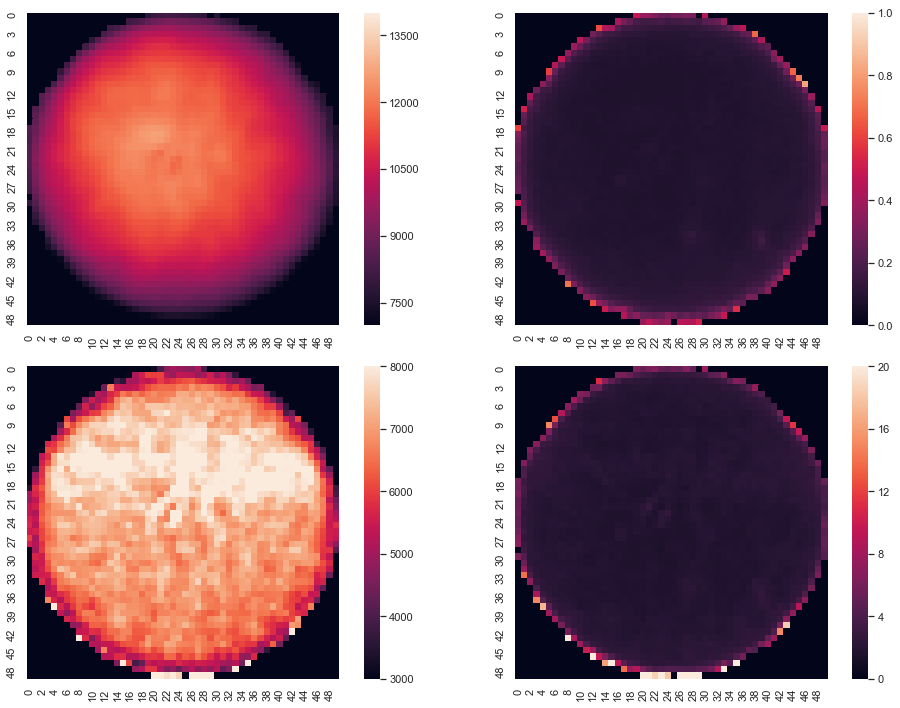

In [164]:
draw_xy_maps(asm,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 20),
            showPlots = False,
            figsize=(14,10))
plt.savefig(output_plots+'/lt_e0_xy_maps/lt_e0_xy_'+str(run_number)+'.png')
plt.savefig(summary_outputs+'maps.png')

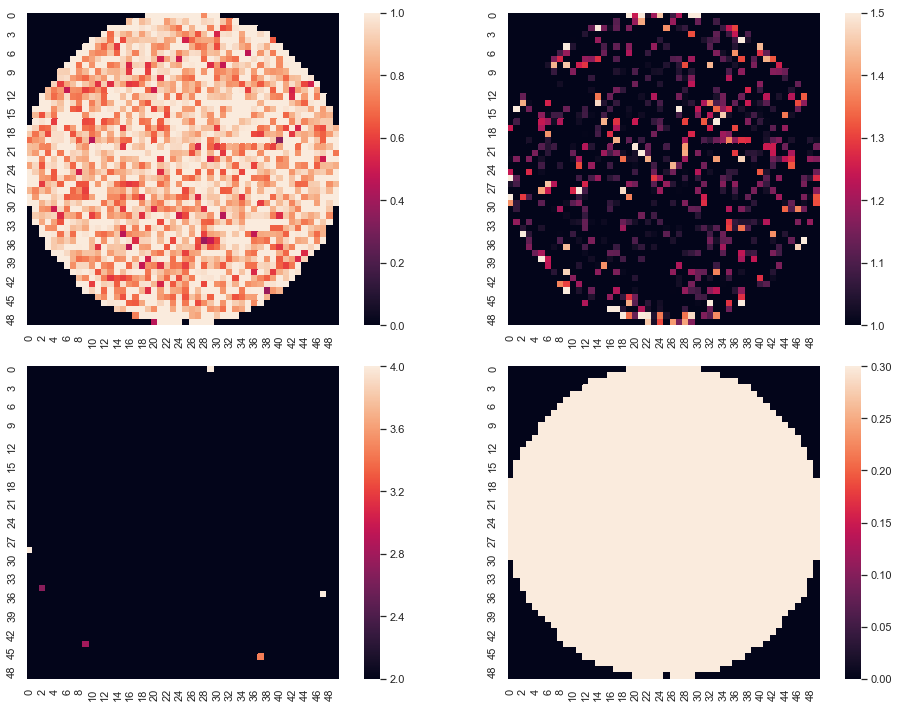

In [92]:
# Plot the X2

asmX2 = asm_copy(asm)
asmX2.e0u = asmX2.chi2.copy()
asmX2.ltu = asmX2.chi2.copy()
asmX2.lt = asmX2.chi2.copy()
asmX2.e0 = asmX2.chi2.copy()

draw_xy_maps(asmX2,
            e0lims  = (0, 1),
            ltlims  = (2, 4),
            eulims  = (1, 1.5),
            lulims  = (0, 0.3),
            showPlots = True,
            figsize=(14,10))

In [93]:
import math

# n_min is minimum number of neighbors. You can use this
# to say, for example, "don't fill a point that has only
# one filled in neighbor, wait until more of its
# neighbors have been filled"
def fill_neighborhoods(amap_old, n_min = 5):
    amap = asm_copy(amap_old)
    nbins = len(amap.lt)
    for i in range(0, nbins):
        for j in range(0, nbins):
            if math.isnan(amap.lt[i][j]):
                nbhd_mean_lt = 0
                nbhd_mean_ltu = 0
                nbhd_mean_e0 = 0
                nbhd_mean_e0u = 0
                n_nbhs = 0
                for di in range(max(i-1,0),min(nbins,i+2)):
                    for dj in range(max(j-1,0),min(nbins,j+2)):
                        if not math.isnan(amap_old.lt[di][dj]): # only look at bins that were already filled
                            nbhd_mean_lt += amap_old.lt[di][dj]
                            nbhd_mean_ltu += amap_old.ltu[di][dj]
                            nbhd_mean_e0 += amap_old.e0[di][dj]
                            nbhd_mean_e0u += amap_old.e0u[di][dj]
                            n_nbhs += 1
                if n_nbhs >= n_min:
                    nbhd_mean_lt /= n_nbhs
                    nbhd_mean_ltu /= n_nbhs
                    nbhd_mean_e0 /= n_nbhs
                    nbhd_mean_e0u /= n_nbhs
                    amap.lt[i][j] = nbhd_mean_lt
                    amap.ltu[i][j] = nbhd_mean_ltu
                    amap.e0[i][j] = nbhd_mean_e0
                    amap.e0u[i][j] = nbhd_mean_e0u

    return amap

# Make sure everyone who has at least 5 neighbors is filled,
# then iterate until you're just left with clusters of points
# that all have less than 5 neighbors
def iterate_fill_neighborhoods(amap_old, n_min = 5):
    
    amap_new = asm_copy(amap_old)
    amap_replaced = fill_neighborhoods(amap_new, n_min)
    previous_lts = np.array(amap_replace_nan_by_zero(amap_new).lt)
    replaced_lts = np.array(amap_replace_nan_by_zero(amap_replaced).lt)
    
    # start by iteratively filling those with > 4 neighbors
    while not np.allclose(previous_lts, replaced_lts):
        amap_replaced = fill_neighborhoods(amap_replaced, n_min)
        previous_lts = replaced_lts.copy()
        replaced_lts = np.array(amap_replace_nan_by_zero(amap_replaced).lt)
    
    return amap_replaced

def asm_full(amap):
    for i in range(len(amap.lt)):
        for j in range(len(amap.lt[i])):
            if np.isnan(amap.lt[i][j]):
                return False
    return True

# Start with iterate_fill_neighborhoods, then do the same
# for n_min = 4, then 3, then 2, then 1. Repeat the process
# over until the entire map is full.
def fill_neighborhoods_descending(amap_old):

    amap_new = asm_copy(amap_old)
    
    loop_num = 0
    
    while not asm_full(amap_new):
        loop_num += 1
        print('Working on loop '+str(loop_num)+'...')
        
        for min_neighbors in range(0, 5):
            print('\tNum neighbors = '+str(5 - min_neighbors))
            amap_new = iterate_fill_neighborhoods(amap_new, n_min = (5 - min_neighbors))
    
        draw_xy_maps(amap_new,
                e0lims  = e0_limits,
                ltlims  = lifetime_limits,
                eulims  = (0.0,  1),
                lulims  = (0, 20),
                showPlots = True,
                figsize=(14,10))
        
    return amap_new


Working on loop 1...
	Num neighbors = 5
	Num neighbors = 4
	Num neighbors = 3
	Num neighbors = 2
	Num neighbors = 1


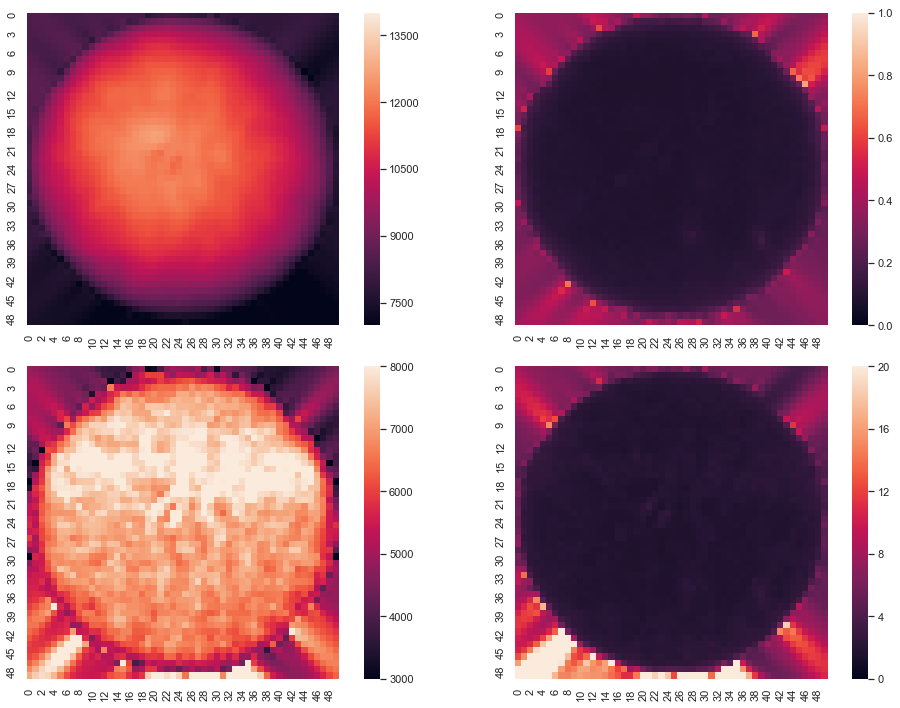

In [94]:
nbhd_iterated = fill_neighborhoods_descending(asm)

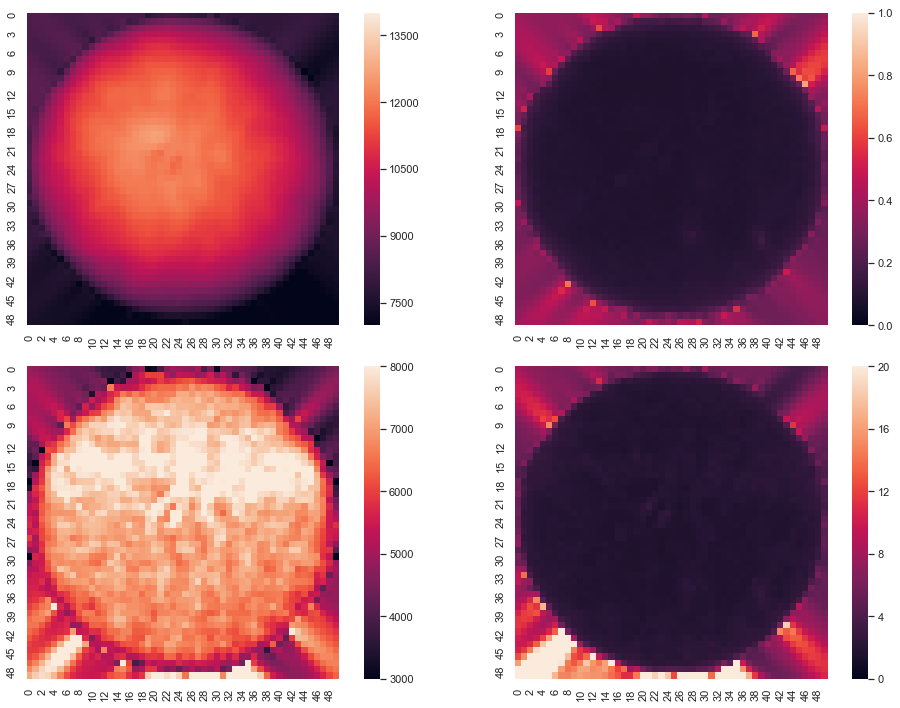

In [95]:
draw_xy_maps(nbhd_iterated,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 20),
            showPlots = False,
            figsize=(14,10))
plt.savefig(output_plots+'/lt_e0_xy_maps/lt_e0_xy_'+str(run_number)+'.png')
plt.savefig(summary_outputs+'maps.png')

In [96]:
asm = nbhd_iterated

In [97]:
asmAv = amap_replace_nan_by_mean(asm, amMean=amv)

In [98]:
bash_mkdir = "mkdir " + output_plots + '/text_outputs'
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

In [99]:
amap_avg_list=amap_average(asmAv)

text_output = open(output_plots+'/text_outputs/outputs_'+str(run_number)+'.txt','w')

text_output.write('chi2='+str(amap_avg_list.chi2)+'\n')
text_output.write('e0='+str(amap_avg_list.e0)+'\n')
text_output.write('lt='+str(amap_avg_list.lt)+'\n')
text_output.write('e0u='+str(amap_avg_list.e0u)+'\n')
text_output.write('ltu='+str(amap_avg_list.ltu)+'\n')

mean = 0
num = 0

mean_low = 0
mean_high = 0

num_low = 0
num_high = 0

variance = 0
var_low = 0
var_high = 0

stdev = 0
stdev_low = 0
stdev_high = 0

zero_filled = asm.lt.fillna(0)
print(len(zero_filled))
for x in range(len(zero_filled)):
    ymax = len(zero_filled[x])
    for y in range(ymax):
        if (zero_filled[x][y] != 0):
            # get the mean
            mean += zero_filled[x][y]
            num += 1
            # get the means for low and high
            if y < ymax / 2:
                num_high += 1
                mean_high += zero_filled[x][y]
            else:
                num_low += 1
                mean_low += zero_filled[x][y]

mean /= num
mean_low /= num_low
mean_high /= num_high

for x in range(len(zero_filled)):
    ymax = len(zero_filled[x])
    for y in range(ymax):
        if (zero_filled[x][y] != 0):
            variance += (zero_filled[x][y] - mean)**2 / num
            if y < ymax / 2:
                var_high += (zero_filled[x][y] - mean_high)**2 / num_high
            else:
                var_low += (zero_filled[x][y] - mean_low)**2 / num_low
            
stdev = variance**0.5
stdev_low = var_low**0.5
stdev_high = var_high**0.5

mean_diff = (mean_high - mean_low) / mean


text_output.write('lt_mean_diff='+str(mean_diff)+'\n')
text_output.write('lt_mean_low='+str(mean_low)+'\n')
text_output.write('lt_mean_high='+str(mean_high)+'\n')
text_output.write('lt_stdev='+str(stdev)+'\n')
text_output.write('lt_stdev_low='+str(stdev_low)+'\n')
text_output.write('lt_stdev_high='+str(stdev_high)+'\n')

text_output.close()

amap_avg_list

50


ASectorMap(chi2=1.168338709529756, e0=9792.062267845655, lt=6664.563152925273, e0u=0.1744659055808157, ltu=4.443796082640494, mapinfo=None)

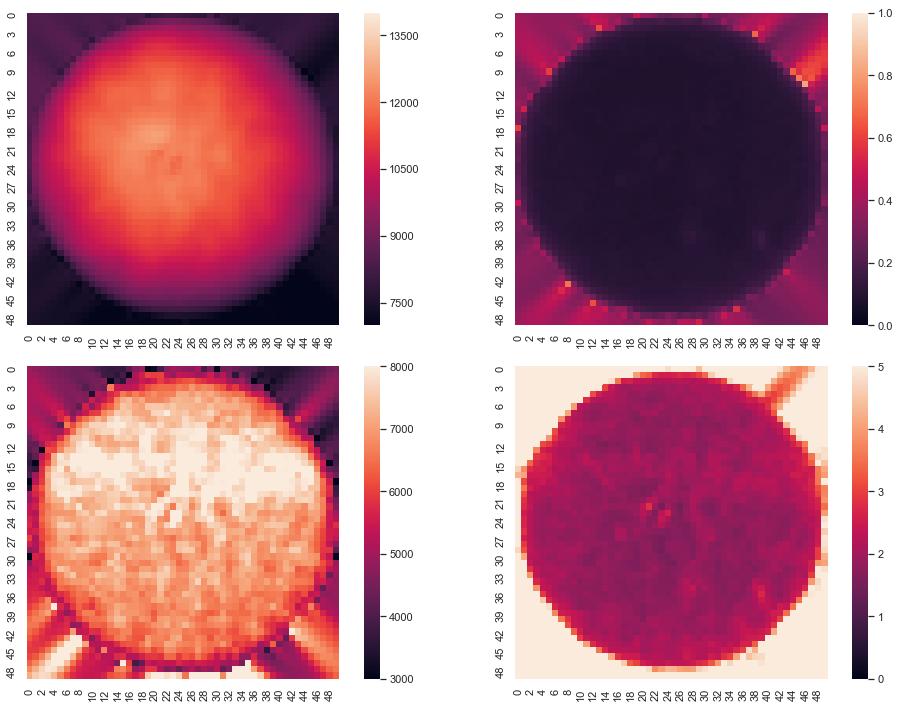

In [100]:
draw_xy_maps(asmAv,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [101]:
asm = add_mapinfo(asmAv, krRanges.X, krRanges.Y, krNbins.X, krNbins.Y, run_number)

In [102]:
bash_mkdir = "mkdir " + fn.emap_file_name[:fn.emap_file_name.rfind('/')]
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

In [103]:
print('The map info is:')
print(asm.mapinfo)
write_maps(asm, filename=fn.emap_file_name)

The map info is:
xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    7472
dtype: int64


### Add temporal corrections

In [104]:
from krcal.core.kr_parevol_functions import kr_time_evolution

tmin = dst.time.min()
pars = kr_time_evolution(ts+tmin, masks, dstfid, asm, xr_map=krRanges.X, yr_map=krRanges.Y, nx_map=krNbins.X, ny_map=krNbins.Y)

pars.to_hdf(fn.emap_file_name, key='time_evolution', mode='a')

### Read back

In [105]:
emaps = read_maps(filename=fn.emap_file_name)

In [106]:
test_pars = pd.read_hdf(fn.emap_file_name, key='time_evolution')

In [107]:
test_pars

,ts,e0,e0u,lt,ltu,dv,dvu,s1w,s1wu,s1h,...,s2e,s2eu,s2q,s2qu,Nsipm,Nsipmu,Xrms,Xrmsu,Yrms,Yrmsu
0,1.566672e+09,12674.792202,1.535222,7141.533152,19.170801,0.913563,0.000220,211.242088,0.192359,2.091231,...,10368.625174,2.739149,560.190847,0.161653,19.986160,0.006500,12.313358,0.017581,12.441208,0.018643
1,1.566676e+09,12674.455605,1.540412,7169.050805,19.279520,0.913443,0.000231,211.172909,0.193116,2.094405,...,10371.909260,2.741773,560.533344,0.161662,19.997251,0.006498,12.290573,0.017470,12.415844,0.018681
2,1.566679e+09,12672.047673,1.541828,7197.655027,19.484276,0.913822,0.000224,211.437695,0.193378,2.094638,...,10373.041462,2.744058,560.378591,0.161752,19.998099,0.006553,12.336632,0.017779,12.468491,0.018921
3,1.566683e+09,12675.453672,1.550247,7161.801307,19.385069,0.913704,0.000218,211.006766,0.193215,2.091828,...,10371.201950,2.739840,560.092355,0.161672,19.980598,0.006510,12.289727,0.017579,12.442047,0.018784
4,1.566686e+09,12675.460911,1.536475,7169.567193,19.274049,0.913674,0.000223,210.850321,0.192284,2.092538,...,10373.338198,2.727378,560.307186,0.161315,19.988158,0.006497,12.312856,0.017535,12.431251,0.018554
5,1.566690e+09,12676.543155,1.545690,7166.935491,19.321501,0.913504,0.000242,211.161990,0.193048,2.093508,...,10374.749359,2.741586,560.303847,0.162078,19.990764,0.006517,12.305787,0.017530,12.430430,0.018821
6,1.566693e+09,12677.035404,1.547220,7143.724220,19.229636,0.913833,0.000215,211.377388,0.193401,2.093176,...,10369.864846,2.746789,560.285850,0.161767,19.991520,0.006528,12.359323,0.017771,12.500695,0.019016
7,1.566697e+09,12676.941650,1.541216,7166.913939,19.272362,0.913765,0.000238,211.105051,0.193070,2.094394,...,10378.311510,2.739811,560.684517,0.160849,19.995068,0.006506,12.309550,0.017555,12.486800,0.018925
8,1.566700e+09,12678.444079,1.548253,7134.752358,19.160714,0.914013,0.000212,210.969031,0.193559,2.098076,...,10373.887689,2.744162,560.650803,0.162114,20.001686,0.006544,12.329180,0.017713,12.484936,0.018972
9,1.566704e+09,12677.718952,1.544730,7187.132976,19.465874,0.913489,0.000238,211.378055,0.194288,2.092821,...,10380.664752,2.748565,560.559538,0.162320,19.997071,0.006523,12.289364,0.017536,12.429086,0.018827


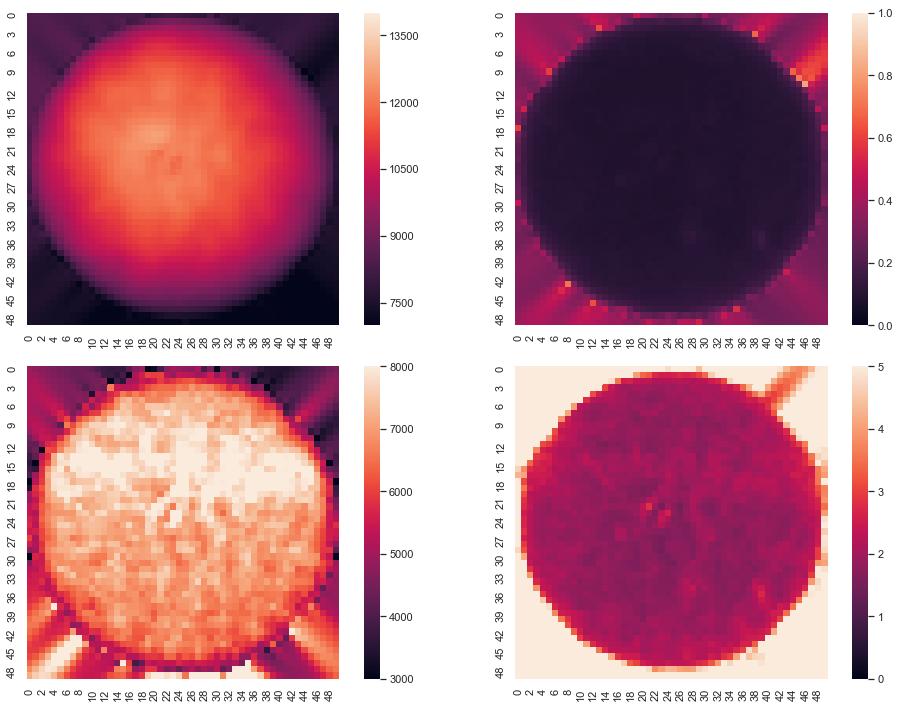

In [108]:
draw_xy_maps(emaps,
            e0lims  = e0_limits,
            ltlims  = lifetime_limits,
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [109]:
amap_average(emaps)

ASectorMap(chi2=1.168338709529756, e0=9792.062267845655, lt=6664.563152925273, e0u=0.1744659055808157, ltu=4.443796082640494, mapinfo=None)

In [110]:
norm = amap_max(emaps)

In [111]:
norm

ASectorMap(chi2=483.9255506004465, e0=12670.188209390328, lt=166122.96985695921, e0u=0.8169661787029566, ltu=501.3894358694335, mapinfo=None)

In [112]:
t0 = time.time()
E0 = e0_xy_correction(dst.S2e.values,
                      dst.X.values,
                      dst.Y.values,
                      E0M = emaps.e0 / norm.e0, 
                      xr  = krRanges.X,
                      yr  = krRanges.Y,
                      nx  = krNbins.X, 
                      ny  = krNbins.Y)


t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 57.86485719680786


In [113]:
t0 = time.time()
# KRP = select_rphi_sectors(dst, DT, E0, dst.S2q, W)
KRP = select_rphi_sectors_df(dst, W) # [edit]
t1 = time.time()
print(f' KRP: t = {t1 -t0}')

 KRP: t = 6.650302886962891


In [114]:
neM = event_map_df(KRP)

In [115]:
neM

,0,1,2,3,4
0,18571,58542,96063,136527,161399
1,18504,56947,99290,145650,167591
2,19399,56964,99293,146009,169587
3,18538,57348,96488,137778,169561
4,19238,55887,97265,127458,159653
5,19808,57342,93576,139165,140081
6,20225,60989,101811,141203,136905
7,19064,55987,100028,137810,148773


In [116]:
neM[0]

0    18571
1    18504
2    19399
3    18538
4    19238
5    19808
6    20225
7    19064
Name: 0, dtype: int64

In [117]:
time_write = time.time()

## Select events in region
- r < 180
- 10 < z < 550
- 5000 < E < 14500

In [118]:
rrange = (0, 180)

ti = timeit(lt_xy_correction)
E = ti(E0, 
       dst.X.values, 
       dst.Y.values,
       dst.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)

sel = in_range(dst.R, *rrange) & in_range(dst.Z, *z_range) &  in_range(E, *e_range)
kse = kr_event(dst, DT, E, dst.S2q, sel)  # kse = krypton selected event

Time spent in lt_xy_correction: 53.372887134552 s


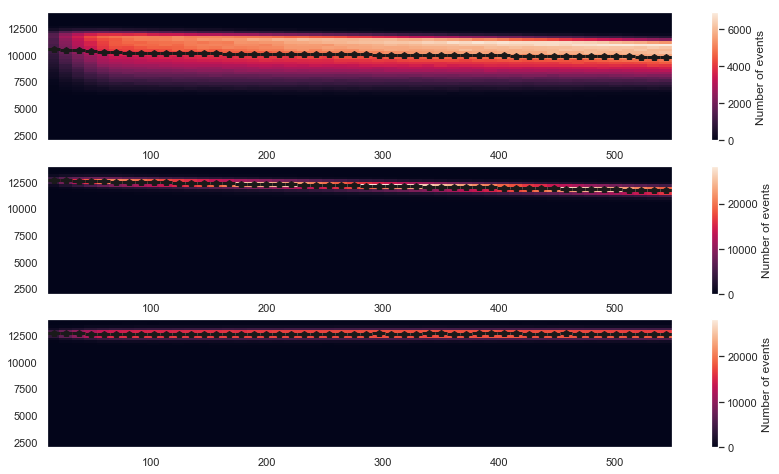

In [119]:
fig = plt.figure(figsize=(14,8))

ax      = fig.add_subplot(3, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

ax      = fig.add_subplot(3, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

ax      = fig.add_subplot(3, 1, 3)
nevt = h2(dst.Z, E, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

plt.savefig(summary_outputs+'CorrectionLT.png')

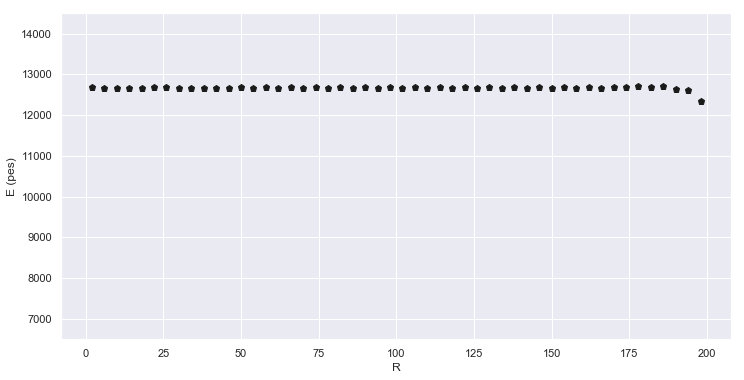

In [120]:
energy_X_profile(dst.R, E, xnbins = num_xy_bins, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14500),  
                 figsize=(12,6))
plt.savefig(summary_outputs+'RProfile.png')

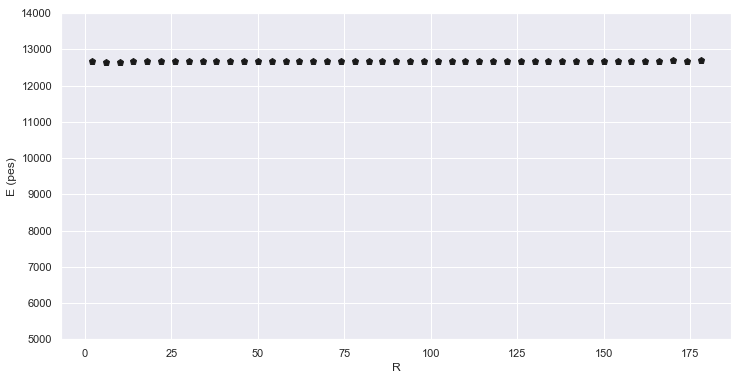

In [121]:
energy_X_profile(kse.R, kse.E, xnbins = num_xy_bins, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))
plt.savefig(summary_outputs+'RProfileC.png')

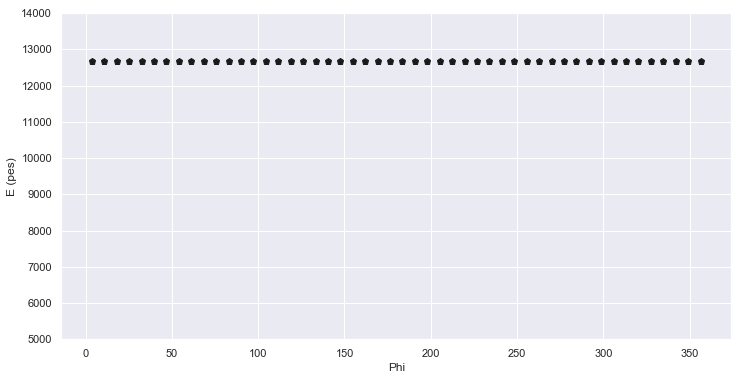

In [122]:
energy_X_profile(phirad_to_deg(kse.Phi), kse.E, xnbins = num_xy_bins, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=e_range,  
                 figsize=(12,6))
plt.savefig(summary_outputs+'PhiProfile.png')

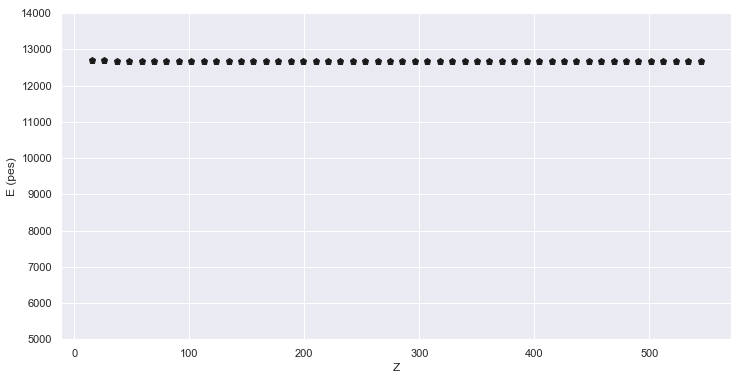

In [123]:
energy_X_profile(kse.Z, kse.E, xnbins = num_xy_bins, xrange=z_range, xlabel = 'Z',
                 erange=e_range,   
                 figsize=(12,6))
plt.savefig(summary_outputs+'ZProfile.png')

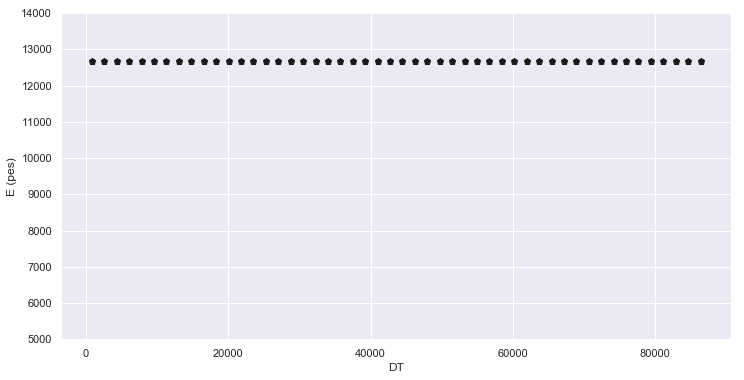

In [124]:
energy_X_profile(kse.DT, kse.E, xnbins = num_xy_bins, xrange=(kse.DT[0], kse.DT[-1]), xlabel = 'DT',
                 erange=e_range,   
                 figsize=(12,6))
plt.savefig(summary_outputs+'TProfile.png')

/Users/jmhaefner/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


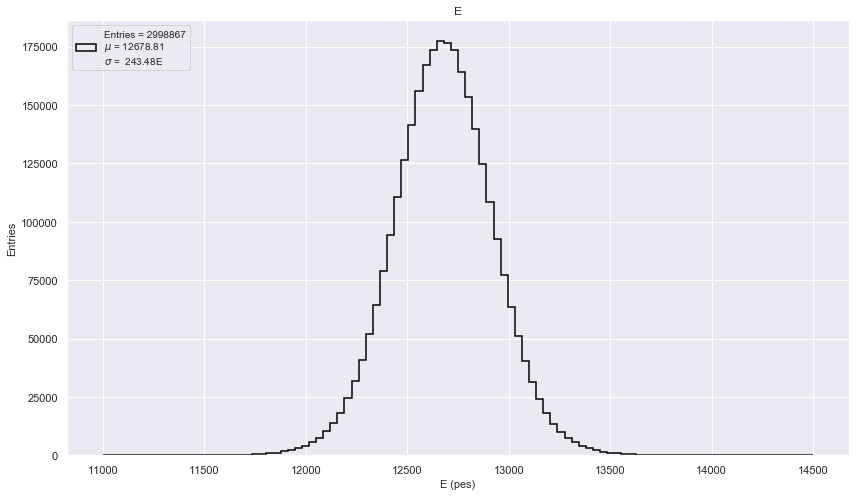

In [125]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 1, 1)

(_)     = h1(kse.E,  bins = 100, range =(11000,14500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 1, 1)

In [86]:
dst[dst.keys()[0]]

0                 1
1                 2
2                 5
3                 6
4                 7
5                 8
6                11
7                12
8                13
9                14
10               21
11               24
12               26
13               28
14               29
15               30
16               31
17               44
18               45
19               46
20               49
21               50
22               57
23               65
24               66
25               88
26               90
27               91
28               92
29               94
             ...   
3774984    11048126
3774985    11048128
3774986    11048129
3774989    11048136
3774993    11048150
3774995    11048152
3774999    11048160
3775000    11048173
3775001    11048178
3775002    11048186
3775003    11048187
3775005    11048209
3775006    11048212
3775007    11048222
3775009    11048224
3775010    11048225
3775011    11048234
3775013    11048240
3775015    11048242


In [87]:
dst.keys()

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [138]:
kse.Z

array([496.18209839, 345.79559326, 382.46813965, ..., 261.46264648,
       175.71632385, 111.3769455 ])

In [ ]:
badRs = []

In [ ]:
badZs = []

In [ ]:
badEs = []

In [168]:
badcount = 0

for i in range(len(kse.X)):
    if i % 100000 == 0:
        print(i)
    x = kse.X[i]
    y = kse.Y[i]
    for v in cutcells:
        xmin = v[0] * 8 - 200
        xmax = xmin + 8
        ymin = v[1] * 8 - 200
        ymax = ymin + 8
        if xmin <= x <= xmax and ymin <= y <= ymax:
            badcount += 1

print('Total bad count =', badcount)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
Total bad count = 0


In [172]:
print(cutcells)
print('Cut locations:')
for v in cutcells:
    xmin = v[0] * 8 - 200
    xmax = xmin + 8
    ymin = v[1] * 8 - 200
    ymax = ymin + 8
    print('x in', (xmin, xmax), ' and y in', (ymin, ymax), '( rmin =', np.sqrt(xmin**2+ymin**2),')')

[(0, 29), (2, 35), (9, 44), (29, 0), (37, 46), (47, 36)]
Cut locations:
x in (-200, -192)  and y in (32, 40) ( rmin = 202.54382241875462 )
x in (-184, -176)  and y in (80, 88) ( rmin = 200.63897926375125 )
x in (-128, -120)  and y in (152, 160) ( rmin = 198.71587757398754 )
x in (32, 40)  and y in (-200, -192) ( rmin = 202.54382241875462 )
x in (96, 104)  and y in (168, 176) ( rmin = 193.49418595916518 )
x in (176, 184)  and y in (88, 96) ( rmin = 196.7739820199815 )


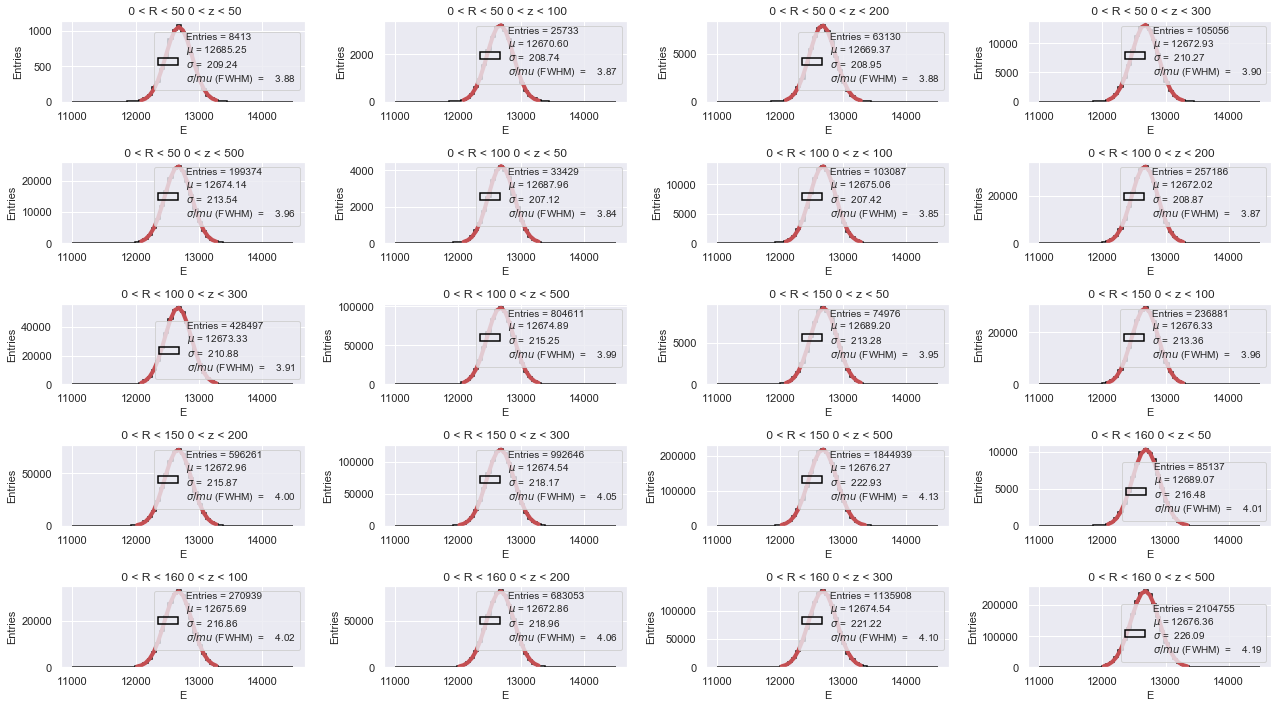

In [109]:
Ri = (50, 100,150,160)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, kse.R, kse.Z, kse.E,
                    enbins = 53,
                    erange = (11e+3, 14500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))

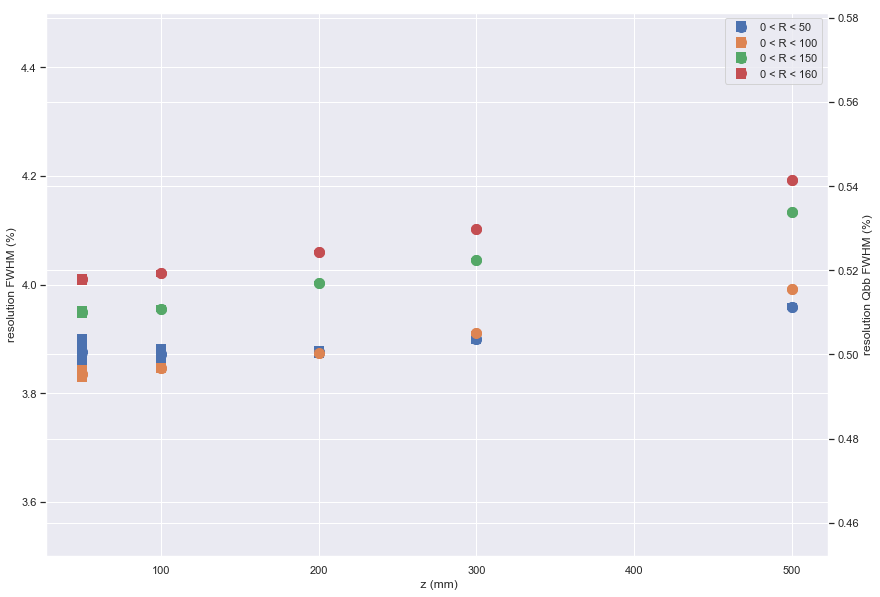

In [110]:
plot_resolution_r_z(Ri, Zi, FC, FCE)

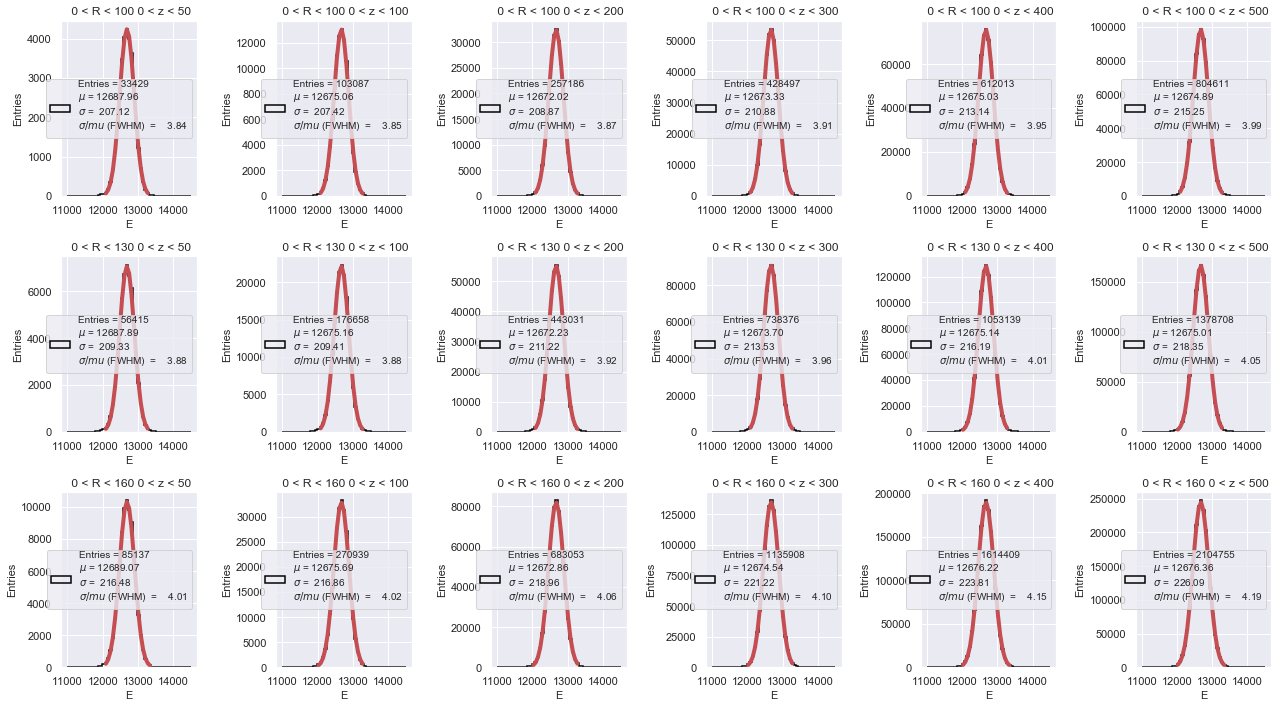

In [111]:
Ri = (100,130,160)
Zi = (50, 100,200,300,400,500)

FC, FCE = resolution_r_z(Ri, Zi, kse.R, kse.Z, kse.E,
                    enbins = 53,
                    erange = (11e+3, 14500),
                    ixy = (3,6),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))
plt.savefig(summary_outputs+'ResoFit.png')

In [112]:
min_res = min([min(np.array(FC).flatten())-0.1, 3.6])
max_res = max([max(np.array(FC).flatten())+0.1, 4.5])
min_res = round(10*min_res) / 10
max_res = round(10*max_res) / 10

In [113]:
bash_mkdir = "mkdir " + output_plots+'/res_vs_rz'
process = subprocess.Popen(bash_mkdir, stdout=subprocess.PIPE, shell=True).wait()

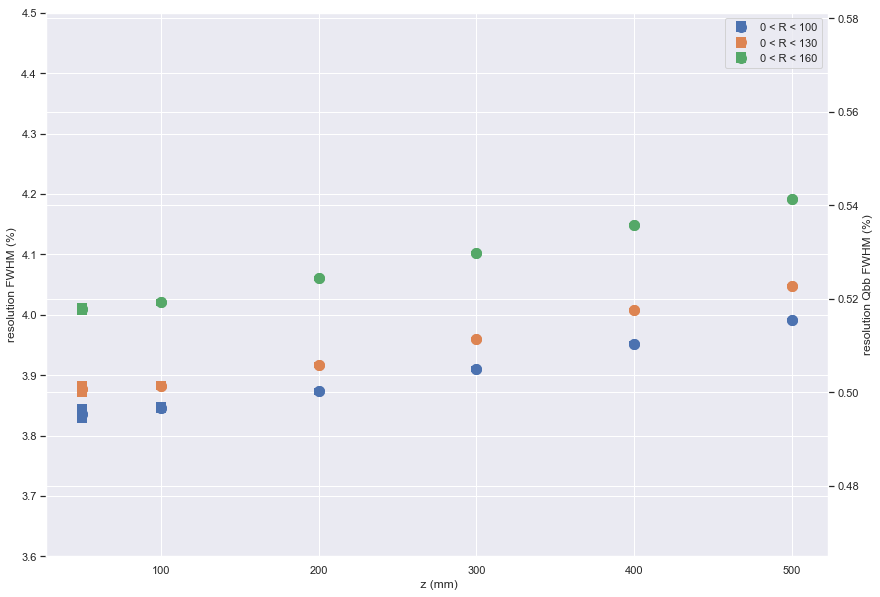

In [114]:
plot_resolution_r_z(Ri, Zi, FC, FCE, showPlots = False, r_range=(min_res, max_res))
plt.savefig(output_plots+'/res_vs_rz/res_vs_rz_'+str(run_number)+'.png')
plt.savefig(summary_outputs+'ResoVsZR.png')

In [115]:
plot_output_dir = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/ltMaps/plot_parameters/'
plot_outputs = open(plot_output_dir+'plot_outputs_'+str(run_number)+analysis_tag+'.txt','w+')

In [116]:
def to_output(mylist, name):
    return name+':'+str(list(mylist))+'\n'

In [117]:
plot_outputs.write(to_output(Ri, 'Ri'))
plot_outputs.write(to_output(Zi, 'Zi'))
plot_outputs.write(to_output(fps.ts, 'fps.ts'))
plot_outputs.write(to_output(fps.e0, 'fps.e0'))
plot_outputs.write(to_output(fps.e0u, 'fps.e0u'))
plot_outputs.write(to_output(fps.lt, 'fps.lt'))
plot_outputs.write(to_output(fps.ltu, 'fps.ltu'))
plot_outputs.write(to_output(fps.c2, 'fps.c2'))
plot_outputs.write(to_output(FC.values.T.tolist(), 'FC'))
plot_outputs.write(to_output(FCE.values.T.tolist(), 'FCE'))
#plot_outputs.write(to_output(kse.R, 'kse.R'))
#plot_outputs.write(to_output(kse.E, 'kse.E'))
#plot_outputs.write(to_output(kse.E, 'kse.Z'))
#plot_outputs.write(to_output(kse.DT, 'kse.DT'))
#plot_outputs.write(to_output(E, 'E'))
#plot_outputs.write(to_output(dst.Z, 'dst.Z'))
#plot_outputs.write(to_output(dst.S2e, 'dst.S2e'))
#plot_outputs.write(to_output(E0, 'E0'))
plot_outputs.close()

In [118]:
param_file = plot_output_dir+'plot_outputs_'+str(run_number)+analysis_tag+'.txt'

In [119]:
def list_params(param_file):
    params = []
    plot_params = open(param_file, 'r')
    for line in plot_params.readlines():
        params.append(line[0:line.find(':')])
    plot_params.close()
    return params

In [120]:
print(list_params(param_file))

['Ri', 'Zi', 'fps.ts', 'fps.e0', 'fps.e0u', 'fps.lt', 'fps.ltu', 'fps.c2', 'FC', 'FCE']


In [121]:
def get_param(param, param_file):
    plot_params = open(param_file, 'r')
    for line in plot_params.readlines():
        if param == line[0:line.find(':')]:
            plot_params.close()
            return(line[line.find(':')+1:len(line)-1])

In [122]:
print(get_param('Ri', param_file))

[100, 130, 160]


### Time variation monitoring plots

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r7472x2rg190819/EffVsTime.png


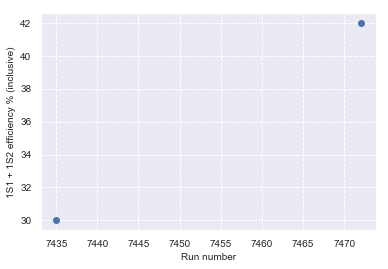

In [123]:
all_runs = []
all_fracs = []

run_min = run_number - 200
run_max = run_number + 1

for run in range(run_min, run_max):

    outer_path = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/data_'+str(run)+analysis_tag+'/'
    full_path = outer_path +'vals_'+str(run)+'.txt'

    try:

        test_file = open(full_path, "r")
        # print(full_path)
        for line in test_file:
            if not line.find('fracS1S2') == -1:
                fracS1S2 = 100 * float(line[9:])
                # print('Frac S1 + S2 = ' + str(fracS1S2))
                all_runs.append(run)
                all_fracs.append(fracS1S2)

    except:
        pass

plt.rc('axes', titlesize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=8)  # fontsize of the figure title

plt.grid(True)
plt.grid(linestyle='--')
plt.plot(all_runs, all_fracs, 'o')
plt.ylabel('1S1 + 1S2 efficiency % (inclusive)')
plt.xlabel('Run number')

plt.savefig(summary_outputs+'EffVsTime.png')
print('Plot saved to '+summary_outputs+'EffVsTime.png')

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r7472x2rg190819/E0VsTime.png


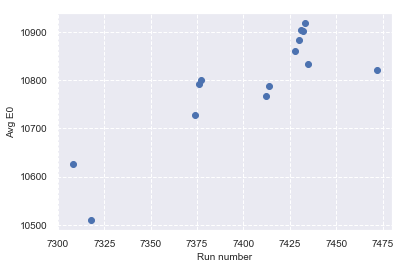

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r7472x2rg190819/LTVsTime.png


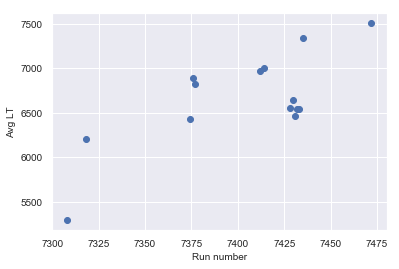

Plot saved to /Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/doc/img/r7472x2rg190819/ResVsTime.png


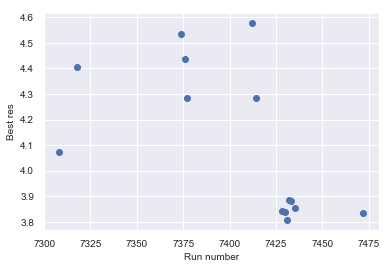

In [124]:
all_runs = []
all_e0s = []
all_lts = []
all_res = []

run_min = run_number - 200
run_max = run_number + 1

for run in range(run_min, run_max):

    outer_path = '/Users/jmhaefner/Development/KryptonCalibration/KrCalibNB_JMH/KrCalibNB/ltMaps/plot_parameters/'
    full_path = outer_path + 'plot_outputs_'+str(run)+analysis_tag+'.txt'
        
    try:
        test_file = open(full_path, "r")
        all_runs.append(run)
        for line in test_file:
            if line.find('fps.e0:') != -1:
                all_e0s.append(np.mean(eval(line[7:])))
            if line.find('fps.lt:') != -1:
                all_lts.append(np.mean(eval(line[7:])))
            if line.find('FC:') != -1:
                all_res.append(eval(line[3:])[0][0])
                # fracS1S2 = 100 * float(line[9:])
                # print('Frac S1 + S2 = ' + str(fracS1S2))
                # all_runs_s1s2.append(run)
                # all_fracs.append(fracS1S2)

    except:
        pass

plt.rc('axes', titlesize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=8)  # fontsize of the figure title

plt.grid(True)
plt.grid(linestyle='--')

plt.plot(all_runs, all_e0s, 'o')
plt.ylabel('Avg E0')
plt.xlabel('Run number')
plt.savefig(summary_outputs+'E0VsTime.png')
print('Plot saved to '+summary_outputs+'E0VsTime.png')
plt.show()

plt.plot(all_runs, all_lts, 'o')
plt.ylabel('Avg LT')
plt.xlabel('Run number')
plt.savefig(summary_outputs+'LTVsTime.png')
print('Plot saved to '+summary_outputs+'LTVsTime.png')
plt.show()

plt.plot(all_runs, all_res, 'o')
plt.ylabel('Best res')
plt.xlabel('Run number')
plt.savefig(summary_outputs+'ResVsTime.png')
print('Plot saved to '+summary_outputs+'ResVsTime.png')
plt.show()

In [125]:
dt_write = time_write - t_start
dt_plots = time.time() - time_write
print('Time to write =', round(dt_write/60.0,1), 'm')
print('Time to show plots =', round(dt_plots/60.0,1), 'm')

Time to write = 3.8 m
Time to show plots = 1.7 m
